## LandCoverNet Model Training

<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

This portion of the tutorial is focused on developing a semantic segmentation model for LandCoverNet data.
<br />
Here:

1. We will load the prepared data as training, test and validation data

2. We will build a segmentation model, train it on the training data, inspect the results on the validation data and make predictions on the test data

### Importing the needed libraries

We will use TensorFlow to build the model. Hence, we will import a number of TensorFlow modules to be used, in addition to our other data related libraries.

For faster model training, it is advisable to use Planetary Computer's TensorFlow GPU server to run the notebook.

In [1]:
import os
import numpy as np

import warnings

from tensorflow.keras.layers import (
    Conv2D,
    Conv2DTranspose,
    Dropout,
    MaxPooling2D,
    concatenate,
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
)
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import random

warnings.filterwarnings("ignore", "Creating an ndarray from ragged")

### Data Preprocessing

The next few steps will address:

1. Loading and preprocessing the prepared data consisting of the source images and labels

2. Splitting the preprocessed images and labels into the training, validation and test data sets

3. A sanity check to visualise our preprocessed data sets. This ensures everything from the previous two steps adds up.

#### Loading and Preprocessing the data

We will load the prepared data defined by the least cloudy RGB source images across all labels taken for every quadrimester throughout the year (every three months).

We set up the temporary directory `tmp_dir` to point to the prepared data and loaded it onto `Xys`

In [2]:
tmp_dir = os.path.join(os.getcwd(), "landcovernet")
labels_dir = os.path.join(tmp_dir, "labels")

In [4]:
with open(os.path.join(tmp_dir, "items.pkl"), "rb") as fp:
    Xys = pickle.load(fp)  # load data

Next, we will preprocess and extract the images and labels respectively.

Since we obtained three RGB images from each season in the data preparation notebook, we will combine/concatenate those images into a single numpy array consisting of (3x3)= 9 bands

We define the function `process_xy(Xys)` to take care of this.
The axis for the images were also swapped, as seen in `temp.swapaxes(i,j)` and the three images concatenated.

This produces the 'X' data for images in the shape `(length of Xys, image height, image width, number of channels)`, which in our case will be `(1980, 256, 256, 9)`.

Likewise, we have the 'Y' data in the shape `(length of Xys, image height, image width)`, which in our case will be `(1980, 256, 256)`

In [5]:
def process_xy(Xys):  # process x and y
    """
    Ths function will process Xys into the desired X and Y
    variables which we need for model development. It returns
    them as numpy arrays
    """
    total = 0
    temp = []
    total_list = []
    for i in range(0, len(Xys)):
        temp.append(Xys[i][0].data)
    for i in range(0, len(Xys)):
        total += len(Xys[i][0])
        # saves the index of the label's first image, then the next label's
        # first image, etc.
        total_list.append(total)
    # print(temp.shape)
    for i in range(0, len(total_list) - 1):
        if (
            total_list[i + 1] != total_list[i] + 3
        ):  # the label does not contain three source images as desired
            outlier = total_list[i]
    temp = [it for sub in temp for it in sub]
    temp = np.asarray(temp)
    temp = temp.swapaxes(1, 2)  # transform axis to desired shape
    temp = temp.swapaxes(2, 3)
    X_mod = []
    for item in range(0, len(temp)):
        if item == outlier:
            pass
        else:
            X_mod.append(list(temp[item]))
    del temp
    del total_list
    X_mod = np.asarray(X_mod)
    flat_list = []
    for i in range(0, len(X_mod), 3):
        flat_list.append(
            list(np.concatenate(X_mod[i : i + 3], axis=2))
        )  # concatenate the data
    flat_list = np.asarray(flat_list)
    del X_mod
    Y = np.zeros((len(Xys), 256, 256), dtype=np.float32)
    for j in range(
        0, len(Xys)
    ):  # labels for the source images belonging to a label item
        Y[j] = Xys[j][1][0].data
    return flat_list, Y

In [6]:
X, Y = process_xy(Xys)  # extract x and y

#### Splitting the data

We will split the data into three non-overlapping data sets; the training, validation and test data sets.

Much of the training will be on the training set, containing 70% of the data, while the validation and test sets will contain 30% of the data (15% each).

We will use Scikit-learn's `train_test_split` for this. We also delete the X and Y variables thereafter to free some memory as they have served their purposes.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3
)  # 70% split for training data
x_test, x_val, y_test, y_val = train_test_split(
    x_test, y_test, test_size=0.5
)  # 15% each for test and validation data
del X  # clear memory
del Y

In [8]:
import gc

gc.collect()

0

In [8]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(1386, 256, 256, 9)
(1386, 256, 256)
(297, 256, 256, 9)
(297, 256, 256)
(297, 256, 256, 9)
(297, 256, 256)


#### Sanity Check

We will just make a sanity check by visualising a random training image and its label to make sure they fit.

We will choose the second image within the concantenated image to visualise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


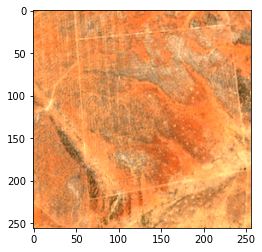

In [28]:
# view a random image
train_id = random.randint(0, len(x_train) - 1)
plt.imshow(
    x_train[train_id][:, :, 3:6] * 2
)  # chose the second image [3:6] in the concatenated image

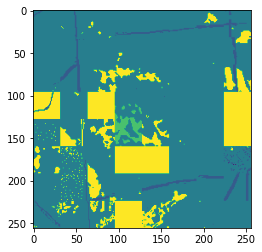

In [25]:
plt.imshow(y_train[train_id])  # display corresponding label

We can see that they match, so there was no problem with the data pre-processing stage

#### Building the U-Net architecture
This model was thanks to YOUCEF GUICHI on Kaggle's  Aerial Semantic Segmentation Drone Dataset.

Their implementation can be found [here](https://www.kaggle.com/yesa911/aerial-semantic-segmentation-96-acc).

For this tutorial, some tweaks were made on the referenced implementation to suit our application.

We will define the convolution block `conv_block` tor the contracting path. The contracting path is a typical convolutional network that consists of repeated application of convolutions, each followed by a rectified linear unit (ReLU) and a max pooling operation.
The purpose of the contracting path is to reduce (contract) the spatial information while feature information is increased.
<br />
This represents the encoder portion of the model.
<br />
Hence, the `Conv2D` layer is used for this. We will choose the default number of filters, `n_filters` to be 32, using the 'relu' activation function.

We will also define the upsampling block for the expanding path. The expanding path combines optimally, the high-level feature information and the information from the skip-connections, which copies a cropped version of the feature maps in the contracting path.
<br />
To implement this, the `Conv2DTranspose` layer was used, with the parameters defined.

For both paths, we chose the `kernel_size`, as 3, which is the size of a convolutional filter.

In [10]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    # code reference: https://www.kaggle.com/yesa911/aerial-semantic-segmentation-96-acc
    conv = Conv2D(
        n_filters,
        kernel_size=3,
        activation="relu",
        padding="same",
        kernel_initializer=tf.keras.initializers.HeNormal(),
    )(inputs)
    conv = Conv2D(
        n_filters,
        kernel_size=3,
        activation="relu",
        padding="same",
        kernel_initializer=tf.keras.initializers.HeNormal(),
    )(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(conv)

    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection


def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = Conv2DTranspose(n_filters, kernel_size=3, strides=(2, 2), padding="same")(
        expansive_input
    )

    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(
        n_filters,
        kernel_size=3,
        activation="relu",
        padding="same",
        kernel_initializer=tf.keras.initializers.HeNormal(),
    )(merge)

    conv = Conv2D(
        n_filters,
        kernel_size=3,
        activation="relu",
        padding="same",
        kernel_initializer=tf.keras.initializers.HeNormal(),
    )(conv)

    return conv

In [11]:
def unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=8):
    # code reference: https://www.kaggle.com/yesa911/aerial-semantic-segmentation-96-acc
    inputs = tf.keras.Input(input_size)
    # inputs = BatchNormalization()(inputs) # we can learn the normalization step
    # inputs = Dropout(0.5)(inputs)
    # contracting path
    cblock1 = conv_block(inputs, n_filters)

    cblock2 = conv_block(cblock1[0], 2 * n_filters)

    cblock3 = conv_block(cblock2[0], 4 * n_filters)

    cblock4 = conv_block(cblock3[0], 8 * n_filters, dropout_prob=0.3)

    cblock5 = conv_block(cblock4[0], 16 * n_filters, dropout_prob=0.3, max_pooling=None)

    # expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1], 8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)

    conv9 = Conv2D(
        n_filters, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(ublock9)
    # conv9 = BatchNormalization()(conv9)
    conv10 = Conv2D(n_classes, kernel_size=1, padding="same")(conv9)
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

We will then build the model based on those defined paths and display the built model.

The image height, image width and number of channels (`img_height`, `img_width`, `num_channels`) as 256, 256, 9 respectively, as defined by the shape of the input image described.

In [13]:
img_height = 256
img_width = 256
num_channels = 9  # modify since we have 9 channels instead

unet = unet_model((img_height, img_width, num_channels))

In [14]:
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 9) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 32) 2624        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_21[0][0]                  
____________________________________________________________________________________________

We will define a `model_checkpoint` which will be used to save the model as the validation loss declines.

`model_earlyStopping` also terminates the training process if the validation loss doesn't increase after a certain number of epochs represented by the `patience`. In this case, we're using 50 epochs

In [19]:
# save the model based on best validation loss
checkpoint_path = os.path.join(tmp_dir, "unet_model.hdf5")
model_checkpoint = ModelCheckpoint(
    checkpoint_path, monitor="val_loss", verbose=1, save_best_only=True
)
# stop training if no improvements after 50 epochs
model_earlyStopping = EarlyStopping(min_delta=0.001, patience=50)

Next, we compile the model. We will use the Adam optimizer, with a learning rate of 3e-4.
The loss defined is the sparse categorical cross-entropy loss (since we have the label dimension of 256x256) and we chose the performance to be judged by the model's accuracy.

In [22]:
# setting up and compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003, name="Adam")
loss = loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
unet.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

### Training the Model

We will train the model on the data sets. We will choose a batch size of 16. The steps per epoch was calculated as the `(length of the training data)//batch size`.

The validation steps as `(length of the validation data)//batch size`.

The `model_checkpoint` and `model_earlyStopping` were also defined into the `callbacks`.

In [23]:
batch_size = 16
history = unet.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // batch_size,
    validation_steps=len(x_val) // batch_size,
    batch_size=batch_size,
    epochs=100,
    callbacks=[model_checkpoint, model_earlyStopping],
)

2022-02-28 23:48:55.446867: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3269984256 exceeds 10% of free system memory.
2022-02-28 23:48:55.943699: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-28 23:48:55.965384: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2445410000 Hz


Epoch 1/100


2022-02-28 23:48:56.933316: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-02-28 23:48:59.621233: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-02-28 23:48:59.772307: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-02-28 23:49:01.455656: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


86/86 [==============================] - 123s 337ms/step - loss: 1.7958 - accuracy: 0.3338 - val_loss: 1.5575 - val_accuracy: 0.3477

Epoch 00001: val_loss improved from inf to 1.55745, saving model to /home/jovyan/PlanetaryComputerExamples/landcovnet/unet_model.hdf5
Epoch 2/100
86/86 [==============================] - 118s 328ms/step - loss: 1.5182 - accuracy: 0.3648 - val_loss: 1.5356 - val_accuracy: 0.3547

Epoch 00002: val_loss improved from 1.55745 to 1.53557, saving model to /home/jovyan/PlanetaryComputerExamples/landcovnet/unet_model.hdf5
Epoch 3/100
86/86 [==============================] - 28s 329ms/step - loss: 1.4885 - accuracy: 0.3681 - val_loss: 1.5318 - val_accuracy: 0.3553

Epoch 00003: val_loss improved from 1.53557 to 1.53175, saving model to /home/jovyan/PlanetaryComputerExamples/landcovnet/unet_model.hdf5
Epoch 4/100
86/86 [==============================] - 28s 332ms/step - loss: 1.4986 - accuracy: 0.3635 - val_loss: 1.5306 - val_accuracy: 0.3552

Epoch 00004: val_los

### Visualising the Model Results

First, we can inspect the loss and accuracy curves for the number of epochs defined in the training process.

This was done for both the training and test losses and accuracies, shown in the figures below

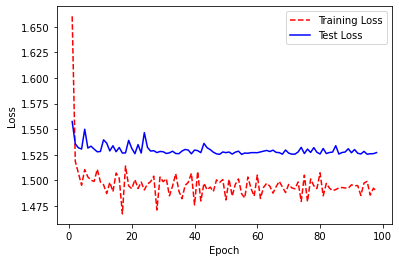

In [24]:
# Get training and test loss histories
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show();

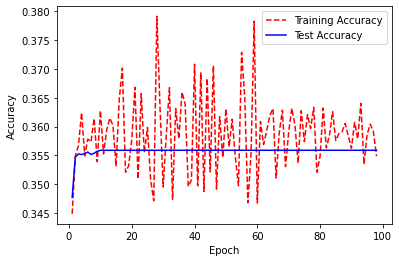

In [25]:
# Get training and test loss histories
training_loss = history.history["accuracy"]
test_loss = history.history["val_accuracy"]

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show();

Next, we will load the model from the saved directory to make predictions as shown

In [10]:
loaded_model = tf.keras.models.load_model(checkpoint_path)

In [12]:
import random

i = random.randint(0, len(x_train) - 1)
pred_mask = loaded_model.predict(np.expand_dims(x_train[i], 0))
pred_mask = np.argmax(pred_mask, axis=-1)
pred_mask = pred_mask[0]

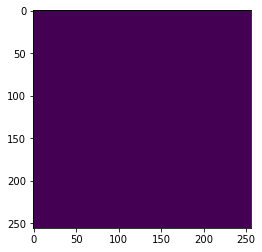

In [13]:
plt.imshow(pred_mask)

Next, we will visualise the model results on the test set, showing the true image, the true label and the predicted label

To obtain the loss and accuracy scores for the test image, we use the `model.evaluate` method, which in our case is `loaded_model.evaluate` while to obtain the label prediction, we use the `mdoel.predict` method, which in our case is `loaded_model.predict`.

We will visualise the true colour image, the true label and predicted label below. We will just display the first of the concatenated source image.

1/1 [==============================] - 0s 26ms/step - loss: 1.3529 - accuracy: 0.7004


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1.3529329299926758, 0.7004241943359375]
3


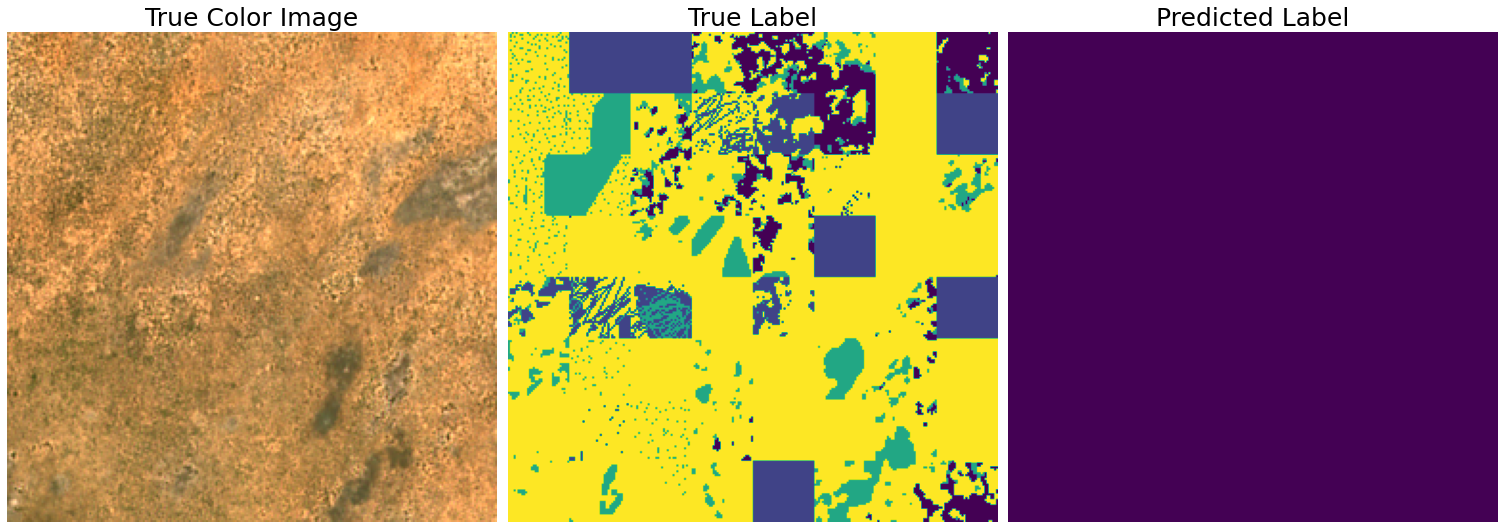

In [22]:
import random

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 10.80))
i = random.randint(0, len(x_test) - 1)
test_result = loaded_model.evaluate(
    np.expand_dims(x_test[i], 0), np.expand_dims(y_test[i], 0)
)
pred_mask = loaded_model.predict(np.expand_dims(x_test[i], 0))
pred_mask = np.argmax(pred_mask, axis=-1)
pred_mask = pred_mask[0]
print(test_result)  # print results on the random field
print(i)  # print ID
# Perform a sanity check on some random training samples
plt.subplot(1, 3, 1)
fontsize = 25
axes[0].imshow((x_test[i][:, :, 0:3]) * 2)  # display first image
plt.title("True Color Image", fontdict={"fontsize": fontsize})
plt.axis("off")
plt.subplot(1, 3, 2)
axes[1].imshow(y_test[i])
plt.title("True Label", fontdict={"fontsize": fontsize})  # display actual label
plt.axis("off")
plt.subplot(1, 3, 3)
axes[2].imshow(pred_mask)  # for predicted label
plt.title("Predicted Label", fontdict={"fontsize": fontsize})
plt.axis("off")
fig.tight_layout()

#### Future Work

There appears to be some class imbalance in the data as majority of the pixels fall under label 8 (index 7). This represents about 30% of the data as shown:

In [24]:
(unique, counts) = np.unique(y_train, return_counts=True)
print(unique, counts)
sum = 0
percentage = []
for i in counts:
    sum += i
for i in counts:
    percentage.append(((i / sum) * 100))
percentage

[0. 1. 2. 3. 4. 5. 6. 7.] [   68451  1996871  2451778 15068808    68629 24191081 14130223 32857055]


[0.07535926191321698,
 2.198400676336467,
 2.6992181334832703,
 16.589593268060064,
 0.07555522615947421,
 26.63251097928222,
 15.556283705850356,
 36.17307874891493]

We can see it in the calculation that it covers 36% of the data, while class 1 represents a meagre 0.075% of the data.

Hence, a possible improvement to the model would be to take this class imbalance into account for model training